# Training Fundamentals

## Training with Test Set

In [1]:
from tensorflow.keras.datasets import mnist

2023-03-03 16:03:11.095180: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


## One-hot encoding


In `model.compile`, the `loss` params for `categorical_crossentropy` and `sparse_categorical_crossentropy` may be confusingly similar, but they are not:

- `categorical_crossentropy`: Use this crossentropy loss function when there are two or more label classes. We expect labels to be provided in a one_hot representation. If you want to provide labels as integers, please use SparseCategoricalCrossentropy loss. [^1]
- `sparse_categorical_crossentropy`: Use this crossentropy loss function when there are two or more label classes. We expect labels to be provided as integers. If you want to provide labels using one-hot representation, please use CategoricalCrossentropy loss. [^2]

[^1]: https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class
[^2]: https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class

In [3]:
from tensorflow.keras.utils import to_categorical

# One-hot encoding can be done using this method.
to_categorical([0, 1, 2, 3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

Some useful `fit` parameters:
- epochs: number of iterations to train the model
- validation_split: 0.1 means use 10% training data for validation

In [4]:
import tensorflow.experimental.numpy as np

## Checkpointing and early stopping

### Checkpoint

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = "mymodel-{epoch:02d}.ckpt"
checkpoint = ModelCheckpoint(filepath)
# model.fit(X_train, y_train, epochs=epochs, callbacks=[checkpoint])
# Run this to see the options.
# ModelCheckpoint?

In [6]:
checkpoint = ModelCheckpoint(
    filepath, save_freq=4
)  # Create a checkpoint for every fourth epoch

In [7]:
checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor="val_acc")

### Early stopping

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Sets an early stop when the validation loss has stopped reducing for 3 epochs.
earlystop = EarlyStopping(monitor="val_acc", patience=3)

## Hyperparameters


Hyperparameters are used to train the model, but are not part of the trained model itself.

In [9]:
from tensorflow.keras import Sequential

model = Sequential()
# Uncomment this to see other parameters.
# model.fit?

### Batch Size

Three types of gradient descent algorithm
- stochastic gradient descent
- batch gradient descent
- mini-batch gradient descent


In _stochastic gradient descent_, the model is updated after each example is fed through during training.
In _batch gradient descent_, the error loss per example is calculated as each example is fed through during training, but the updating of the model is done at the end of each epoch.

### Adaptive Learning Rate

In [10]:
from tensorflow.keras import optimizers

optimizer = optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, epsilon=None, weight_decay=0.0
)
model.compile(loss="mean_squared_error", optimizer=optimizer)

## Image Processing

### With PIL

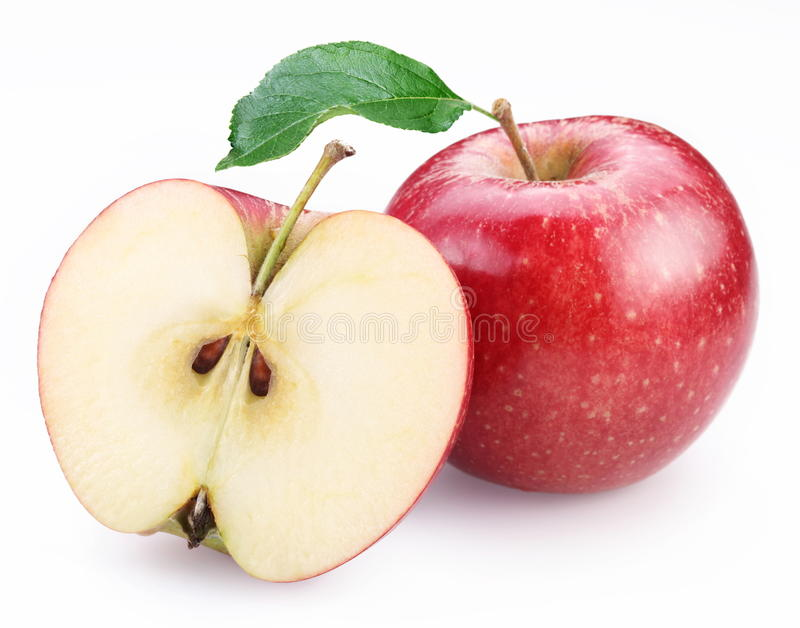

In [11]:
from PIL import Image

image = Image.open("./assets/apple.jpeg")
image

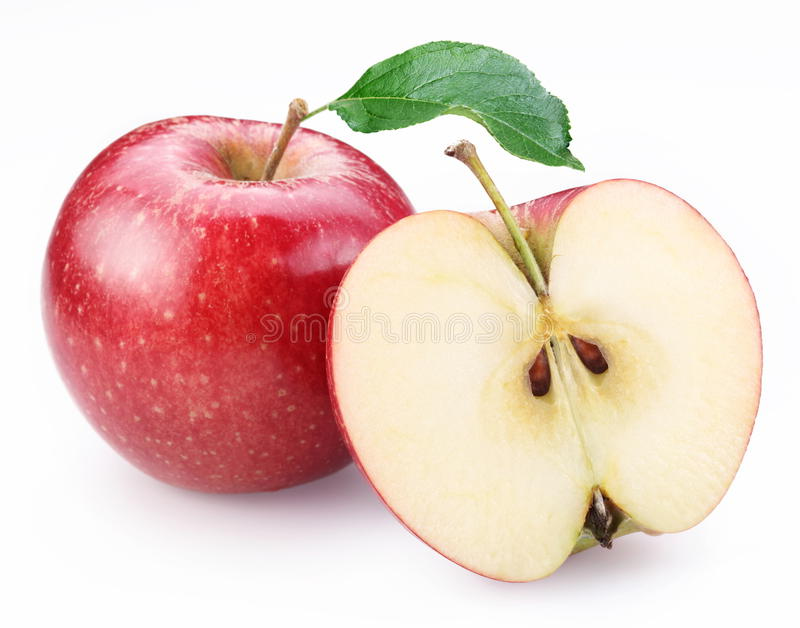

In [12]:
flip = image.transpose(Image.FLIP_LEFT_RIGHT)
flip

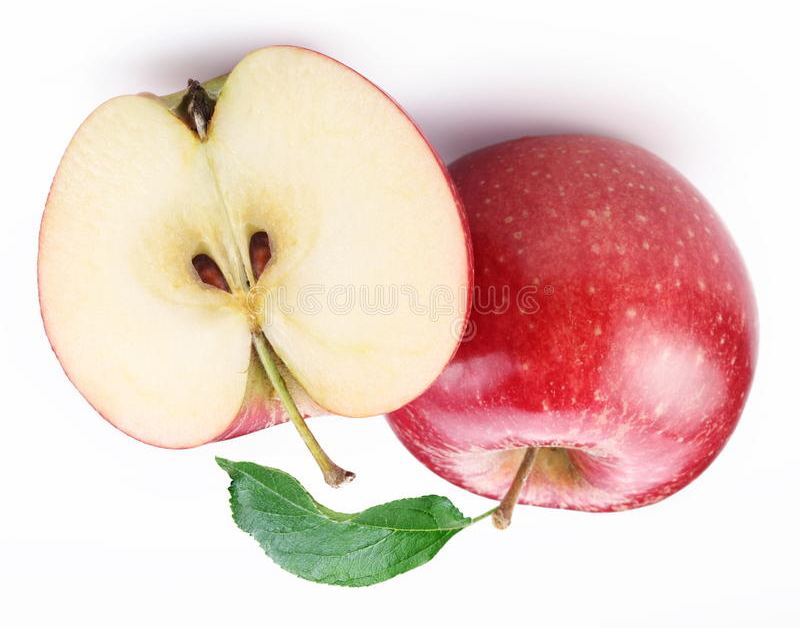

In [13]:
flip = image.transpose(Image.FLIP_TOP_BOTTOM)
flip

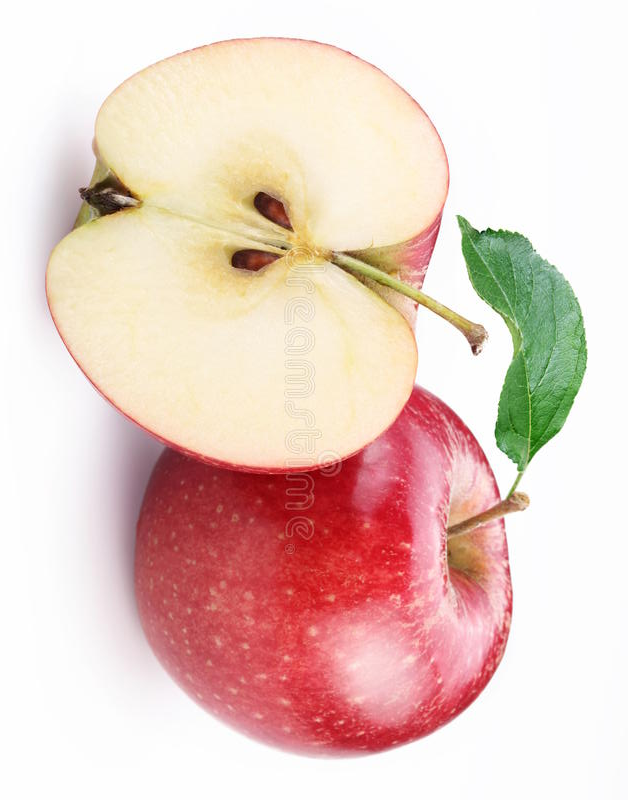

In [14]:
rotate = image.transpose(Image.ROTATE_90)
rotate = image.transpose(Image.ROTATE_180)
rotate = image.transpose(Image.ROTATE_270)
rotate

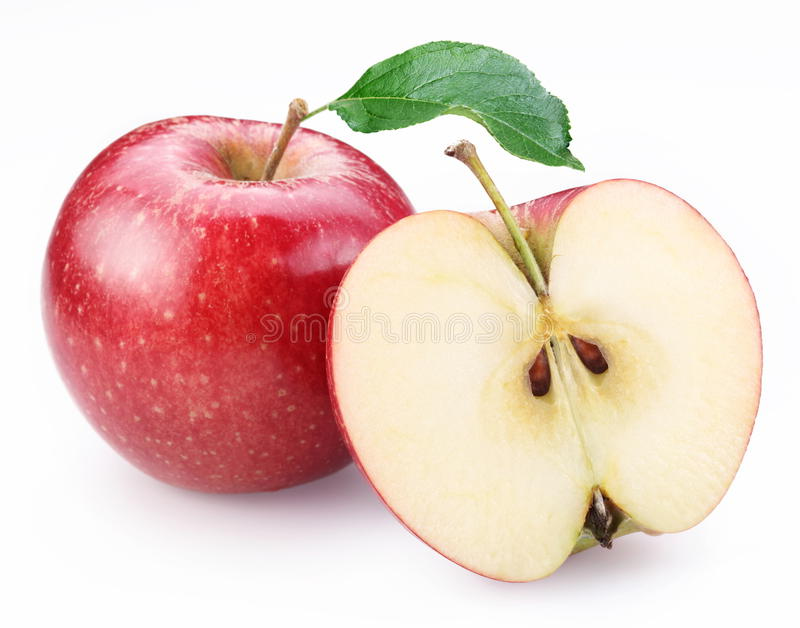

In [15]:
from PIL import ImageOps

ImageOps.mirror(image)

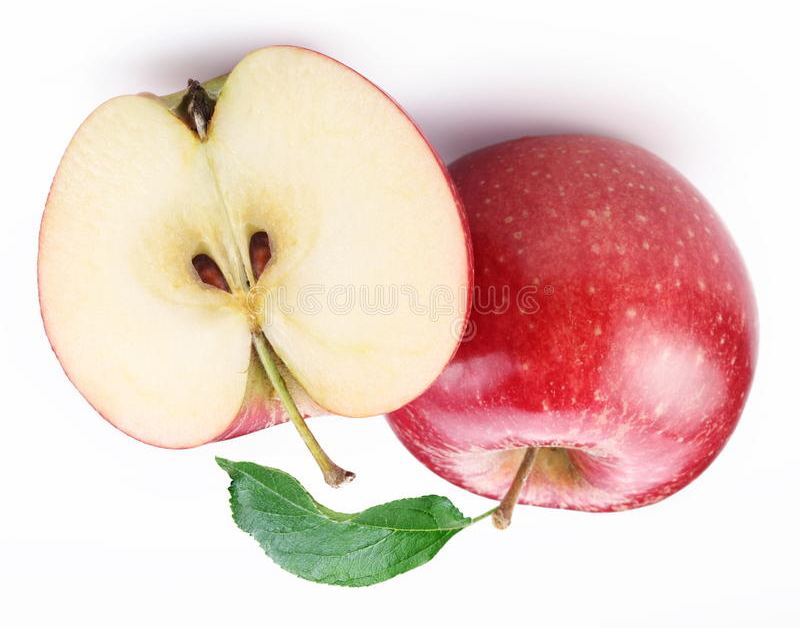

In [16]:
ImageOps.flip(image)

### With OpenCV

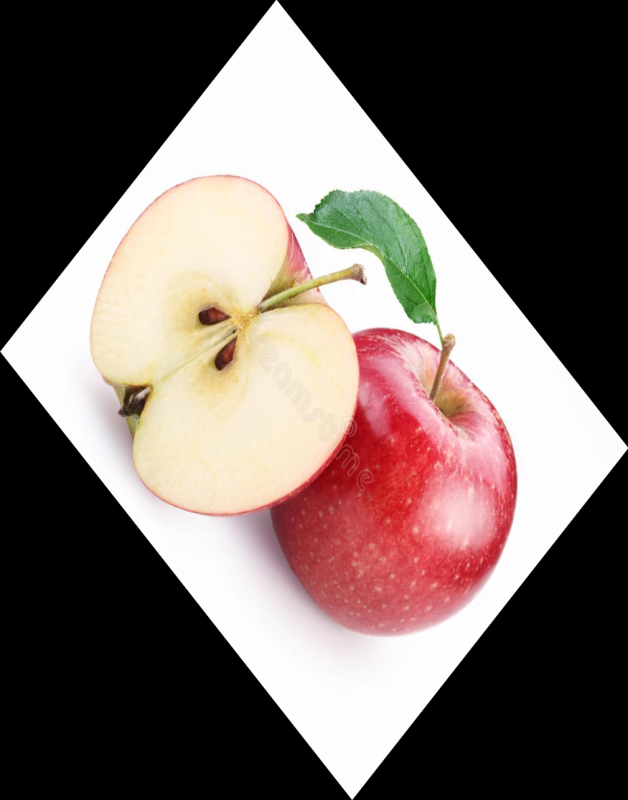

In [22]:
import cv2
import imutils
import matplotlib.pyplot as plt

image = cv2.imread("./assets/apple.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
flip_vertical = cv2.flip(image, 1)
flip_horizontal = cv2.flip(image, 0)

# The correct way to handle rotation is to rotate it within
# a large bounding area, so that none of the image is clipped,
# and then resize the rotate image back to its original size.
image = cv2.imread("./assets/apple.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # openCV reads image as BGR
shape = (image.shape[0], image.shape[1])
rotate = imutils.rotate_bound(image, 45)
rotate = cv2.resize(rotate, shape, interpolation=cv2.INTER_AREA)
Image.fromarray(rotate)

### With Numpy

In [18]:
import numpy as np

image = cv2.imread("./assets/apple.jpeg")
flip_vertical = np.flip(image, 1)
flip_horizontal = np.flip(image, 0)
rotate90 = np.rot90(image, 1)
rotate180 = np.rot90(image, 2)
rotate270 = np.rot90(image, 3)

height, width = image.shape[0], image.shape[1]
roll = np.roll(image, height // 10, axis=0)  # Shifts the image down by 10%
roll = np.roll(image, -(height // 10), axis=0)  # Shifts the image up by 10%
roll = np.roll(image, width // 10, axis=1)  # Shifts to the right by 10%
roll = np.roll(image, -(width // 10), axis=1)  # Shifts to the left by 10%

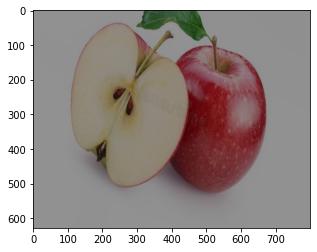

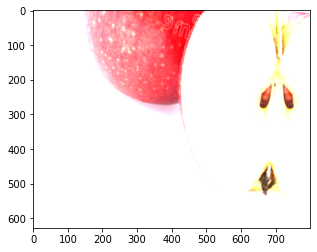

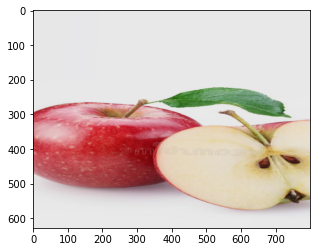

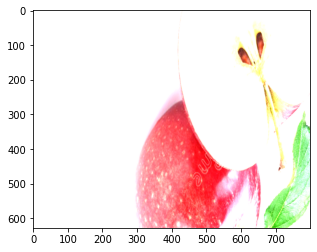

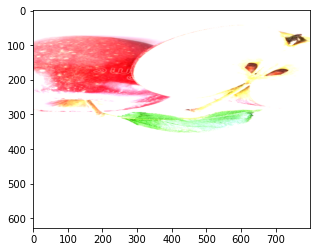

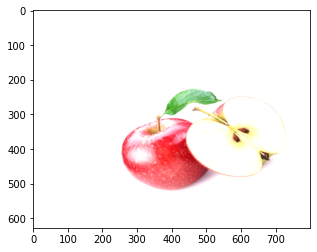

In [21]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image = cv2.imread("./assets/apple.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

batch = np.asarray([image])  # Makes a batch of one image.

datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=60,
    zoom_range=(0.5, 2),
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.5, 2),
)
step = 0
for x in datagen.flow(batch, batch_size=1):
    step += 1
    if step > 6:
        break
    plt.figure()
    # The augmentation changes the pixel data to float, then changes it back to
    # uint8 for displaying the image.
    plt.imshow(x[0].astype(np.uint8))

## Model save/restore

### Save

In [ ]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
model.save("mymodel")  # Saves the model and trained weight and biases
model.save_weights("myweights")  # Saves the trained weights and biases only.

### Restore

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("mymodel")  # Loads a pretrained model.
model.load_weights('myweights') # Loads pretrained weights for the model.